In [23]:
import os

os.environ['DDE_BACKEND'] = 'tensorflow'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import numpy as np
import deepxde as dde

dde.config.set_default_float("float64")
dde.config.set_random_seed(42)
np.random.seed(42)

from deepxde.data import PDE
from deepxde.geometry import TimeDomain
from deepxde.icbc.initial_conditions import IC
from deepxde.icbc import PointSetBC
from deepxde.nn import FNN, PFNN
from deepxde.model import Model
from deepxde.callbacks import VariableValue, EarlyStopping
from deepxde.metrics import mean_squared_error
from scipy.integrate import solve_ivp
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd

from tensorflow.keras.optimizers.schedules import InverseTimeDecay

import sys
sys.path.append('../..')
from utils.custom_models import AdaptativeDataWeightModel

Set the default float type to float64


In [24]:
df = pd.read_csv("../../data/influenza_england_1978_school.csv")
df[:5]

,date,in_bed,convalescent
0,1978-01-22,3,0
1,1978-01-23,8,0
2,1978-01-24,26,0
3,1978-01-25,76,0
4,1978-01-26,225,9


In [25]:
df["date"]

0     1978-01-22
1     1978-01-23
2     1978-01-24
3     1978-01-25
4     1978-01-26
5     1978-01-27
6     1978-01-28
7     1978-01-29
8     1978-01-30
9     1978-01-31
10    1978-02-01
11    1978-02-02
12    1978-02-03
13    1978-02-04
Name: date, dtype: object

In [26]:

data_I = df["in_bed"].to_numpy()
data_I

array([  3,   8,  26,  76, 225, 298, 258, 233, 189, 128,  68,  29,  14,
         4])

In [27]:
t_0, t_f = 0, len(data_I)
gamma = 0.407
N = 763 # population size

In [28]:
I_min, I_max = data_I.min(axis=0), data_I.max(axis=0)
I_mean, I_std = data_I.mean(axis=0), data_I.std(axis=0)

# Z Scaling
# def scale(data):
#     return (data - I_mean) / I_std

# def unscale(data):
#     return data * I_std + I_mean

# Min/Max
def scale(data):
    return (data - I_min) / (I_max - I_min)

def unscale(data):
    return I_min + (I_max - I_min) * data

In [29]:
data_I_scaled = scale(data_I)
I0 = data_I_scaled[0]
S0 = scale(N) - I0

In [30]:
S0, I0

(np.float64(2.5762711864406778), np.float64(0.0))

In [31]:
data_I_scaled

array([0.        , 0.01694915, 0.0779661 , 0.24745763, 0.75254237,
       1.        , 0.86440678, 0.77966102, 0.63050847, 0.42372881,
       0.22033898, 0.08813559, 0.03728814, 0.00338983])

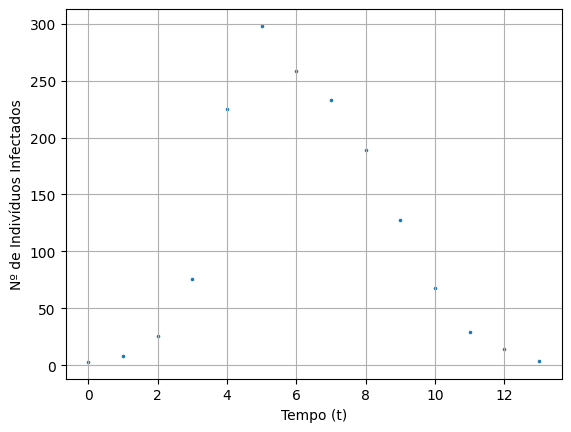

In [32]:
train_t = np.linspace(t_0, t_f - 1, t_f)
plt.scatter(train_t, data_I, s=2.5)
plt.xlabel("Tempo (t)")
plt.ylabel("Nº de Indivíduos Infectados")
plt.grid()
plt.savefig(f"../../images/data-english-board-school.png")
plt.show()

In [ ]:
timeinterval = TimeDomain(t_0, t_f)

def sir_residual(t, y):

    S, I, beta = y[:,0:1], y[:,1:2], y[:,2:3]
    
    dS_dt = dde.gradients.jacobian(y, t, i=0)
    dI_dt = dde.gradients.jacobian(y, t, i=1)

    S_unscaled = unscale(S)
    N_unscaled = N / S_unscaled

    return [
        dS_dt + beta * (S * I / N_unscaled),
        dI_dt - beta * (S * I / N_unscaled) + gamma * I
    ]


# Tensorflow has an issue with lambdas...
def is_on_initial(_, on_initial): return on_initial

def S0_val(_): return S0
def I0_val(_): return I0

ic_S = IC(timeinterval, S0_val, is_on_initial, component=0)
ic_I = IC(timeinterval, I0_val, is_on_initial, component=1)

data_t = train_t.reshape(-1, 1)
data_I_bc = PointSetBC(data_t, data_I_scaled, component=1)

ics = [ic_S, ic_I]
data_conds = [data_I_bc]
conditions = ics + data_conds

data = PDE(
    timeinterval,
    sir_residual,
    conditions,
    num_domain=len(data_I)*2,
    num_boundary=2,
    num_test=len(data_I)//2,
    anchors=data_t
)

n_hidden_layers = 4
hidden_layer_size = 50
topology = [1] + [hidden_layer_size] * n_hidden_layers + [3]
activation = "tanh"
initializer = "Glorot uniform"
optimizer = "adam"
lr = 0.002

eq_w = 1
ic_w = 1
data_w = 1

n_equations = 2

# Com L2
# loss_weights = [eq_w] * n_equations + [ic1_w, ic2_w, ic3_w]  + [data_w] * len(data_conds) + [1]

# Sem L2
loss_weights = [eq_w] * n_equations + [ic_w] * len(ics)  + [data_w] * len(data_conds)

# net = FNN(
#     topology,
#     activation,
#     initializer,
#     # regularization=["L2", 1e-5],
#     # dropout_rate=0.1,
# )

net = PFNN(
    topology,
    activation,
    initializer,
    # regularization=["L2", 1e-5],
    # dropout_rate=0,
)

# model = AdaptativeDataWeightModel(data, net, n_physics=n_equations + len(ics), n_data=1)
model = Model(data, net)

model.compile(
    optimizer,
    lr,
    loss_weights=loss_weights
)


Compiling model...
'compile' took 0.062760 s



In [ ]:
early_stopping = EarlyStopping(min_delta=1e-6, patience=5000)

adam_iterations = 100000

losshistory, train_state = model.train(
    iterations=adam_iterations, 
    display_every=100,
    callbacks=[
        early_stopping
    ]
)

model.compile(
    "L-BFGS", 
    loss_weights=loss_weights
)

dde.optimizers.set_LBFGS_options(
    # ftol=np.finfo(float).eps,
    maxiter=25000,
    ftol=1e-10,
    gtol=1e-12
)

losshistory, train_state = model.train(
    iterations=20000, 
    display_every=100
)

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [3.71e-03, 2.90e-02, 6.64e+00, 0.00e+00, 1.35e-01]    [7.66e-04, 2.09e-02, 6.64e+00, 0.00e+00, 1.35e-01]    []  
100       [1.27e-03, 4.56e-03, 4.31e-05, 1.32e-03, 1.34e-01]    [7.52e-04, 2.41e-03, 4.31e-05, 1.32e-03, 1.34e-01]    []  
200       [4.42e-04, 3.16e-03, 1.78e-06, 1.65e-03, 1.34e-01]    [3.71e-04, 1.63e-03, 1.78e-06, 1.65e-03, 1.34e-01]    []  
300       [3.61e-04, 2.26e-03, 2.48e-06, 1.68e-03, 1.33e-01]    [3.79e-04, 1.10e-03, 2.48e-06, 1.68e-03, 1.33e-01]    []  
400       [3.14e-04, 1.70e-03, 2.83e-06, 1.68e-03, 1.33e-01]    [3.57e-04, 7.68e-04, 2.83e-06, 1.68e-03, 1.33e-01]    []  
500       [2.64e-04, 1.37e-03, 2.40e-06, 1.66e-03, 1.33e-01]    [3.09e-04, 5.72e-04, 2.40e-06, 1.66e-03, 1.33e-01]    []  
600       [2.20e-04, 1.17e-03, 1.73e-06, 1.61e-03, 1.32e-01]    [2.58e-04, 4.73e-04, 1.73e-06, 1.61e-03, 1.32e-01

In [35]:
# model.save("../models/sir-nonoise")
# dde.saveplot(
#     losshistory, 
#     train_state, 
#     issave=True, 
#     isplot=False,
#     output_dir="../losses", 
#     loss_fname=f"loss-sir-nonoise",
#     train_fname=f"train-sir-nonoise",
#     test_fname=f"test-sir-nonoise")

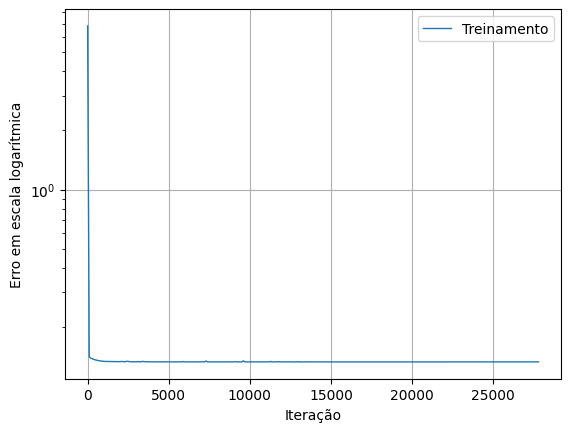

In [36]:
train = np.sum(losshistory.loss_train, axis=1)
plt.semilogy(losshistory.steps, train, "-", label="Treinamento", linewidth=1)
plt.xlabel("Iteração")
plt.ylabel("Erro em escala logarítmica")

plt.legend()
plt.grid()
plt.savefig(f"../../images/loss-english-board-school.png")
plt.show()

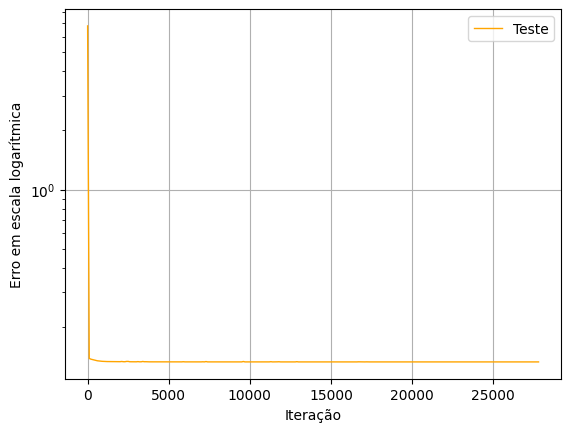

In [37]:
test = np.sum(losshistory.loss_test, axis=1)

plt.semilogy(losshistory.steps, test, "-", label="Teste", color="orange", linewidth=1)

plt.xlabel("Iteração")
plt.ylabel("Erro em escala logarítmica")

plt.legend()
plt.grid()
# plt.savefig(f"../images/sir-loss-nonoise.png")
plt.show()

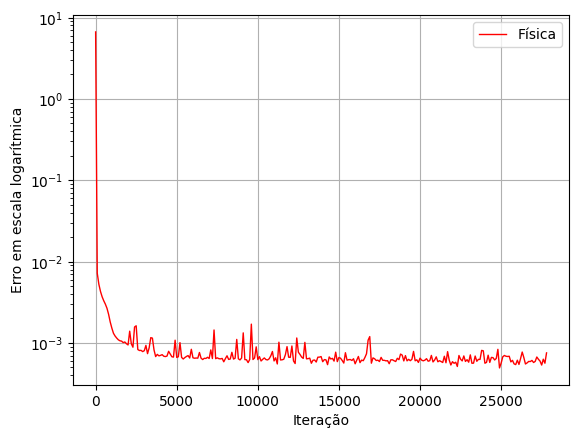

In [38]:
loss_train = np.array(losshistory.loss_train) 

train_phys = np.sum(loss_train[:,:len(ics) + n_equations], axis=1)
plt.semilogy(losshistory.steps, train_phys, "-", label="Física", color="red", linewidth=1)
plt.xlabel("Iteração")
plt.ylabel("Erro em escala logarítmica")
plt.legend()
plt.grid()
plt.show()

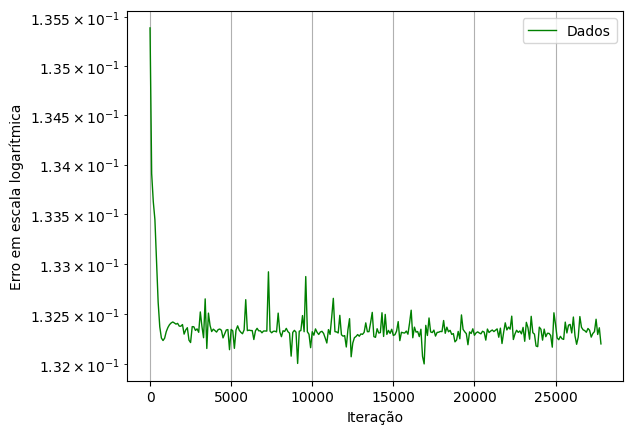

In [39]:
train_data = np.sum(loss_train[:,len(ics) + n_equations:], axis=1)
plt.semilogy(losshistory.steps, train_data, "-", label="Dados", color="green", linewidth=1)
plt.xlabel("Iteração")
plt.ylabel("Erro em escala logarítmica")
plt.legend()
plt.grid()
plt.show()

In [40]:
if isinstance(model, AdaptativeDataWeightModel):
    plt.semilogy(np.arange(len(model.data_weight_hist)), model.data_weight_hist)
    plt.xlabel("iteração")
    plt.ylabel("$\omega_{dados}$")
    plt.savefig("../../images/data-weight-english-board-school.png")
    plt.show()

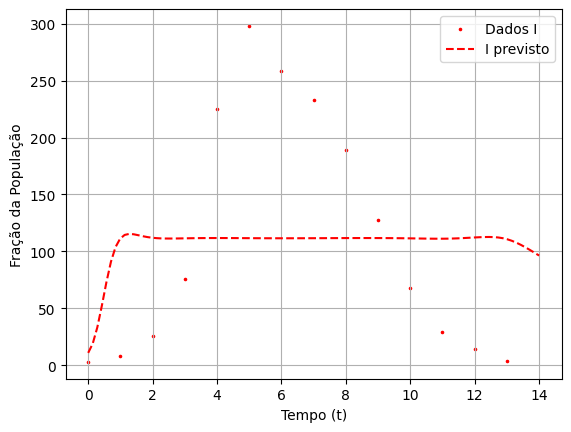

In [41]:
plt.rcParams['text.usetex'] = False
nop_test = 100

test_t = np.linspace(t_0, t_f, nop_test).reshape(-1, 1)
y_pred = model.predict(test_t)

I_pred = unscale(y_pred[:, 1])

plt.scatter(train_t, data_I, label="Dados I", color="red", s=2.5)
plt.plot(test_t, I_pred, label="I previsto", linestyle="--", color="red")

plt.xlabel("Tempo (t)")
plt.ylabel("Fração da População")

plt.legend()
plt.grid()
plt.savefig("../../images/predicted-invected-english-board-school.png")

plt.show()

[]

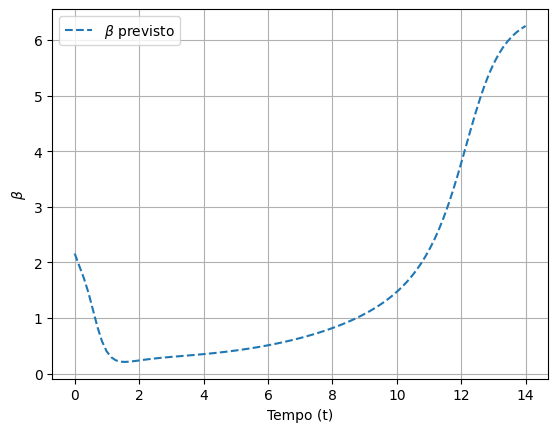

In [42]:
beta_pred = y_pred[:, 2]
plt.plot(test_t, beta_pred, label=r"$\beta$ previsto", linestyle="--")
plt.xlabel("Tempo (t)")
plt.ylabel(r"$\beta$")
plt.legend()
plt.grid()
plt.savefig("../../images/predicted-beta-english-board-school.png")
plt.plot()

[]

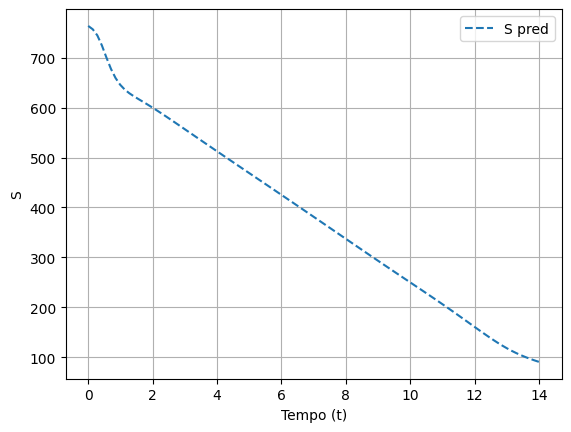

In [43]:
S_pred = unscale(y_pred[:, 0])
plt.plot(test_t, S_pred, label=r"S pred", linestyle="--")
plt.xlabel("Tempo (t)")
plt.ylabel(r"S")
plt.legend()
plt.grid()
plt.plot()

[]

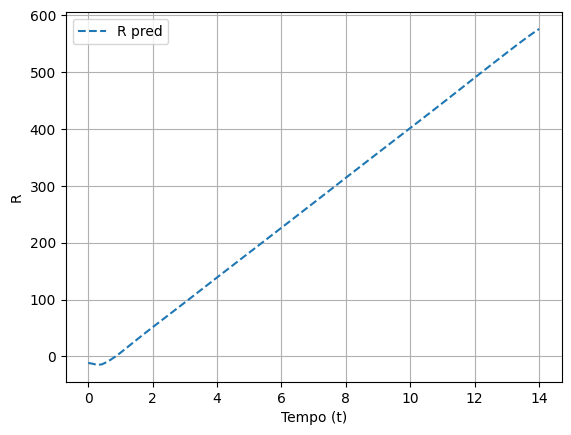

In [44]:
R_pred = N - S_pred - I_pred
plt.plot(test_t, R_pred, label=r"R pred", linestyle="--")
plt.xlabel("Tempo (t)")
plt.ylabel(r"R")
plt.legend()
plt.grid()
plt.plot()